In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

In [8]:
df = pd.read_csv("/content/customers.csv")
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (10695, 11)
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  462643  Female          Yes   38       Yes       Engineer              NaN   
2  466315  Female          Yes   67       Yes       Engineer              1.0   
3  461735    Male          Yes   67       Yes         Lawyer              0.0   
4  462669  Female          Yes   40       Yes  Entertainment              NaN   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
1        Average          3.0  Cat_4            A  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B  
4           High          6.0  Cat_6            A  


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 919.2+ KB


In [10]:
df.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [12]:
df = df.drop(columns=["ID"])

In [14]:
df.fillna({"Work_Experience": 0, "Family_Size": df["Family_Size"].median()}, inplace=True)

In [16]:
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [17]:
label_encoder = LabelEncoder()
df["Segmentation"] = label_encoder.fit_transform(df["Segmentation"])

X = df.drop(columns=["Segmentation"])
y = df["Segmentation"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [29]:
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.relu(self.fc4(x))
        x=self.fc5(x)
        return x

In [30]:
def train_model(model,train_loader,criterion,optimizer,epochs):
  for epoch in range(epochs):
    model.train()
    for X_batch,y_batch in train_loader:
      optimizer.zero_grad()
      outputs=model(X_batch)
      loss=criterion(outputs,y_batch)
      loss.backward()
      optimizer.step()

  if(epoch+1)%10==0:
    print(f'Epoch [{epoch+1}/{epochs}],Loss:{loss.item():.4f}')

In [31]:
model =PeopleClassifier(input_size=X_train.shape[1])
criterion =nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(),lr=0.001)

train_model(model,train_loader,criterion,optimizer,epochs=100)

Epoch [100/100],Loss:1.0499


In [32]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

In [33]:
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])
print("Name: K MADHAVA REDDY")
print("Register No: 212223240064")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Name: K MADHAVA REDDY
Register No: 212223240064
Test Accuracy: 0.48%
Confusion Matrix:
 [[196 147 100 141]
 [102 186 124  78]
 [ 65  99 247  61]
 [112  56  35 390]]
Classification Report:
               precision    recall  f1-score   support

           A       0.41      0.34      0.37       584
           B       0.38      0.38      0.38       490
           C       0.49      0.52      0.51       472
           D       0.58      0.66      0.62       593

    accuracy                           0.48      2139
   macro avg       0.47      0.47      0.47      2139
weighted avg       0.47      0.48      0.47      2139



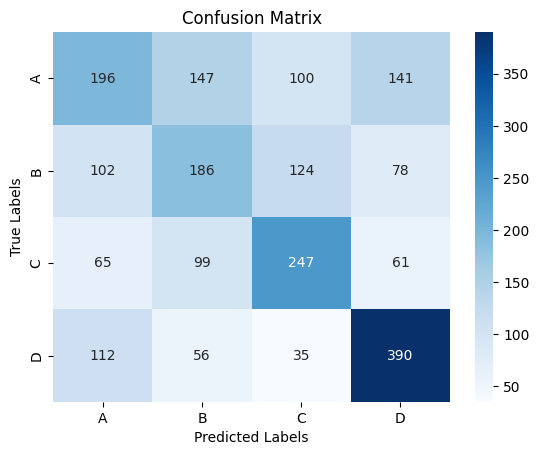

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [37]:
sample_input = X_test[9].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
print("Name: K MADHAVA REDDY")
print("Register No: 212223240064")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[9].item()])[0]}')

Name: K MADHAVA REDDY
Register No: 212223240064
Predicted class for sample input: D
Actual class for sample input: A
